In [48]:
import matplotlib.pyplot as plot
import keras
import tensorflow as tf
from keras.datasets import cifar10
from keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.utils import np_utils
import numpy as np

Стандартные параметры:
* Число эпох уменьшено с 200 до 20, т.к обучение одной модели с 200 эпохами занимает слишком много времени (около 200 минут)

In [49]:
batch_size = 32 # in each iteration, we consider 32 training examples at once
num_epochs = 20 # we iterate 20 times over the entire training set
kernel_size = 3 # we will use 3x3 kernels throughout
pool_size = 2 # we will use 2x2 pooling throughout
conv_depth_1 = 32 # we will initially have 32 kernels per conv. layer...
conv_depth_2 = 64 # ...switching to 64 after the first pooling layer
drop_prob_1 = 0.25 # dropout after pooling with probability 0.25
drop_prob_2 = 0.5 # dropout in the dense layer with probability 0.5
hidden_size = 512 # the dense layer will have 512 neurons

Скачиваем данные и приводим к формату совместимому с tf

In [50]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data() # fetch CIFAR-10 data
num_train, depth, height, width = X_train.shape # there are 50000 training examples in CIFAR-10
num_test = X_test.shape[0] # there are 10000 test examples in CIFAR-10
num_classes = np.unique(y_train).shape[0] # there are 10 image classes
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= np.max(X_train) # Normalise data to [0, 1] range
X_test /= np.max(X_train) # Normalise data to [0, 1] range

Y_train = np_utils.to_categorical(y_train, num_classes) # One- hot encode the labels

Y_test = np_utils.to_categorical(y_test, num_classes) # One-hot encode the labels

Соберём и обучим стандартную модель (на 20 эпохах):

In [51]:
model1 = Sequential(
    [
        Conv2D(conv_depth_1, (kernel_size, kernel_size), padding="same", activation='relu', input_shape=(depth, height, width)),
        Conv2D(conv_depth_1, (kernel_size, kernel_size), padding="same", activation='relu'),
        MaxPooling2D(pool_size=(pool_size, pool_size)),
        Dropout(drop_prob_1),
        Conv2D(conv_depth_2, (kernel_size, kernel_size), padding="same", activation='relu'),
        Conv2D(conv_depth_2, (kernel_size, kernel_size), padding="same", activation='relu'),
        MaxPooling2D(pool_size=(pool_size, pool_size)),
        Dropout(drop_prob_1),
        Flatten(),
        Dense(hidden_size, activation='relu'),
        Dropout(drop_prob_2),
        Dense(num_classes, activation='softmax')
    ]
)
with tf.device("/GPU:0"):
    model1.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(jit_compile=True), metrics=['accuracy'])
    history1 = model1.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, validation_split=0.1)
val_loss1, val_acc1 = model1.evaluate(X_test, Y_test, verbose=1)

Epoch 1/20
1407/1407 [==============================] - 71s 50ms/step - loss: 1.5421 - accuracy: 0.4373 - val_loss: 1.1062 - val_accuracy: 0.6028
Epoch 2/20
1407/1407 [==============================] - 95s 68ms/step - loss: 1.1046 - accuracy: 0.6084 - val_loss: 0.9325 - val_accuracy: 0.6798
Epoch 3/20
1407/1407 [==============================] - 91s 64ms/step - loss: 0.9504 - accuracy: 0.6620 - val_loss: 0.8903 - val_accuracy: 0.6894
Epoch 4/20
1407/1407 [==============================] - 87s 62ms/step - loss: 0.8518 - accuracy: 0.7014 - val_loss: 0.7423 - val_accuracy: 0.7420
Epoch 5/20
1407/1407 [==============================] - 58s 41ms/step - loss: 0.7845 - accuracy: 0.7249 - val_loss: 0.7221 - val_accuracy: 0.7508
Epoch 6/20
1407/1407 [==============================] - 54s 38ms/step - loss: 0.7294 - accuracy: 0.7451 - val_loss: 0.7105 - val_accuracy: 0.7596
Epoch 7/20
1407/1407 [==============================] - 57s 41ms/step - loss: 0.6881 - accuracy: 0.7575 - val_loss: 0.7342 -

1. Выведем результаты прогона тестовых данных через модель
2. Отобразим на графиках попарно изменения loss и val_loss, accuracy и val_accuracy от номера эпохи:

val_loss:  145.76361083984375 val_acc:  0.6255000233650208


<Figure size 1200x600 with 0 Axes>

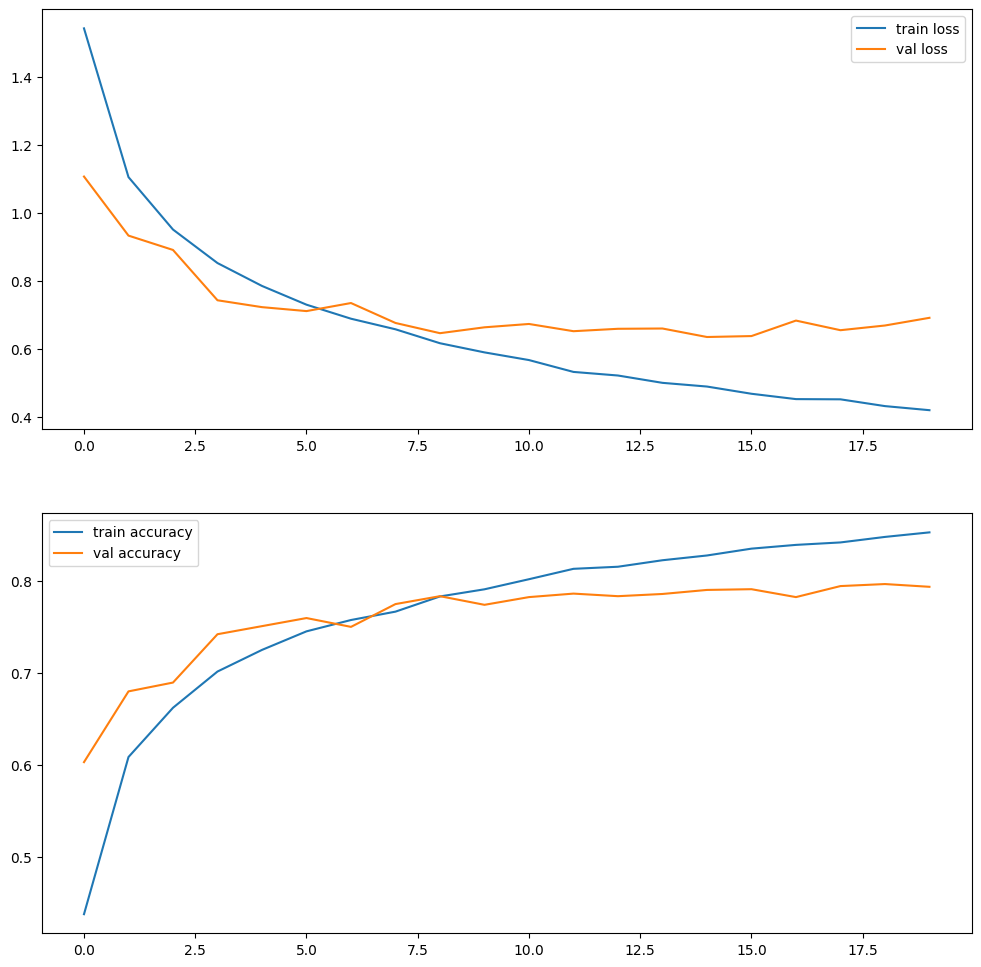

In [52]:
print('val_loss: ', val_loss1, 'val_acc: ', val_acc1)

plot.figure(figsize=(12, 6))

figure, plot_arr = plot.subplots(2)

plot_arr[0].plot(history1.epoch, history1.history['loss'], label='train loss')
plot_arr[0].plot(history1.epoch, history1.history['val_loss'], label='val loss')
plot_arr[0].legend()

plot_arr[1].plot(history1.epoch, history1.history['accuracy'], label='train accuracy')
plot_arr[1].plot(history1.epoch, history1.history['val_accuracy'], label='val accuracy')
plot_arr[1].legend()

plot.show()

Модель 2:

Уберём из изначальной модели все слои Dropout:

In [9]:
model2 = Sequential(
    [
        Conv2D(conv_depth_1, (kernel_size, kernel_size), padding="same", activation='relu', input_shape=(depth, height, width)),
        Conv2D(conv_depth_1, (kernel_size, kernel_size), padding="same", activation='relu'),
        MaxPooling2D(pool_size=(pool_size, pool_size)),
        #Dropout(drop_prob_1), NOTE: rm Dropout
        Conv2D(conv_depth_2, (kernel_size, kernel_size), padding="same", activation='relu'),
        Conv2D(conv_depth_2, (kernel_size, kernel_size), padding="same", activation='relu'),
        MaxPooling2D(pool_size=(pool_size, pool_size)),
        #Dropout(drop_prob_1), NOTE: rm Dropout
        Flatten(),
        Dense(hidden_size, activation='relu'),
        #Dropout(drop_prob_2), NOTE: rm Dropout
        Dense(num_classes, activation='softmax')
    ]
)
with tf.device("/GPU:0"):
    model2.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(jit_compile=True), metrics=['accuracy'])
    history2 = model2.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, validation_split=0.1)
val_loss2, val_acc2 = model2.evaluate(X_test, Y_test, verbose=1)

Epoch 1/20
1407/1407 [==============================] - 52s 36ms/step - loss: 1.3251 - accuracy: 0.5192 - val_loss: 0.9538 - val_accuracy: 0.6630
Epoch 2/20
1407/1407 [==============================] - 41s 29ms/step - loss: 0.8604 - accuracy: 0.6948 - val_loss: 0.8071 - val_accuracy: 0.7152
Epoch 3/20
1407/1407 [==============================] - 41s 29ms/step - loss: 0.6547 - accuracy: 0.7682 - val_loss: 0.7777 - val_accuracy: 0.7394
Epoch 4/20
1407/1407 [==============================] - 41s 29ms/step - loss: 0.4798 - accuracy: 0.8303 - val_loss: 0.7856 - val_accuracy: 0.7448
Epoch 5/20
1407/1407 [==============================] - 41s 29ms/step - loss: 0.3165 - accuracy: 0.8898 - val_loss: 0.8968 - val_accuracy: 0.7482
Epoch 6/20
1407/1407 [==============================] - 41s 29ms/step - loss: 0.2031 - accuracy: 0.9293 - val_loss: 1.0195 - val_accuracy: 0.7412
Epoch 7/20
1407/1407 [==============================] - 41s 29ms/step - loss: 0.1458 - accuracy: 0.9500 - val_loss: 1.1601 -

1. Выведем результаты прогона тестовых данных через модель
2. Отобразим на графиках попарно изменения loss и val_loss, accuracy и val_accuracy от номера эпохи:

val_loss:  862.0443725585938 val_acc:  0.5375999808311462


<Figure size 1200x600 with 0 Axes>

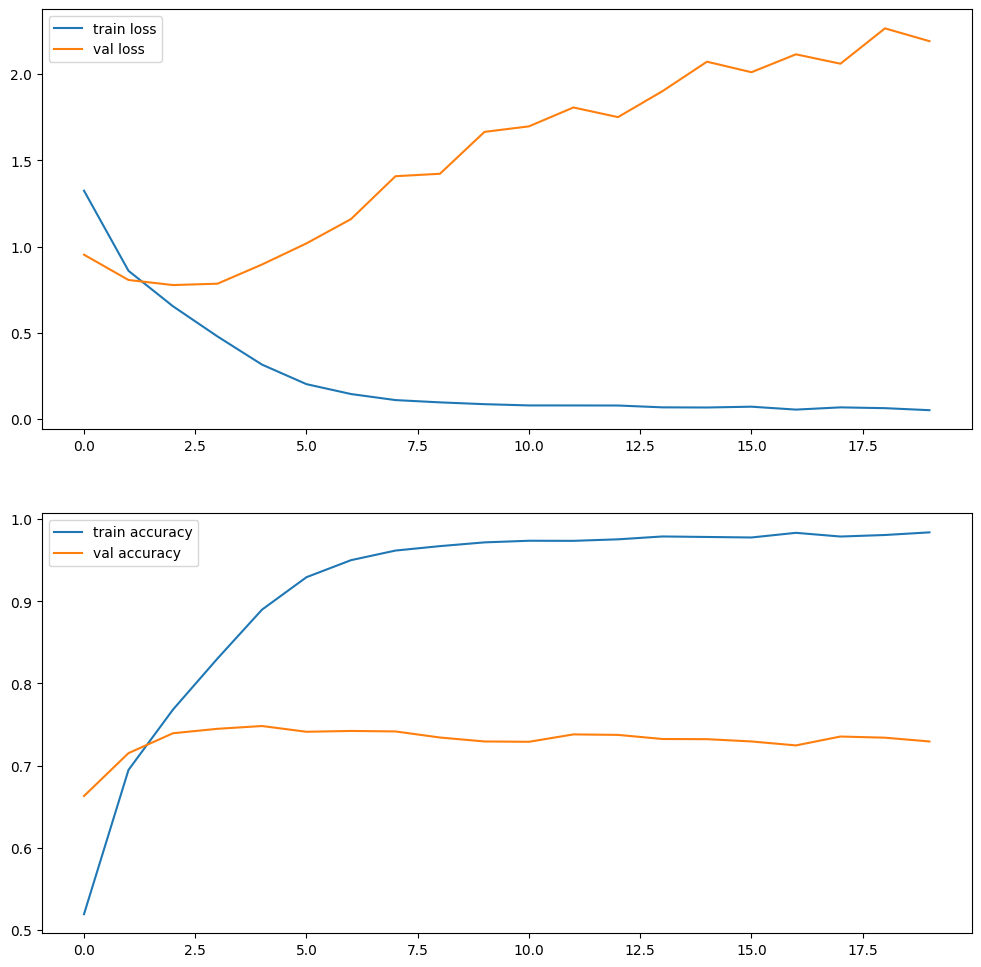

In [55]:
print('val_loss: ', val_loss2, 'val_acc: ', val_acc2)

plot.figure(figsize=(12, 6))

figure, plot_arr = plot.subplots(2)

plot_arr[0].plot(history2.epoch, history2.history['loss'], label='train loss')
plot_arr[0].plot(history2.epoch, history2.history['val_loss'], label='val loss')
plot_arr[0].legend()

plot_arr[1].plot(history2.epoch, history2.history['accuracy'], label='train accuracy')
plot_arr[1].plot(history2.epoch, history2.history['val_accuracy'], label='val accuracy')
plot_arr[1].legend()

plot.show()

Из графиков можно заметить как сильно расходятся значения train loss и val loss, а также train accuracy и val accuracy. Если судить по точности на тренировочных данных, модель показывает хорошие результаты, а по данных для тестирования - плохие. Из этого можно сделать вывод, что модель переобучается

Модель 3:

Возьмём исходную модель, но изменим количество ядер на всех сверточных слоях с 3 на 2:

In [53]:
kernel_size = 2

model3 = Sequential(
    [
        Conv2D(conv_depth_1, (kernel_size, kernel_size), padding="same", activation='relu', input_shape=(depth, height, width)),
        Conv2D(conv_depth_1, (kernel_size, kernel_size), padding="same", activation='relu'),
        MaxPooling2D(pool_size=(pool_size, pool_size)),
        Dropout(drop_prob_1),
        Conv2D(conv_depth_2, (kernel_size, kernel_size), padding="same", activation='relu'),
        Conv2D(conv_depth_2, (kernel_size, kernel_size), padding="same", activation='relu'),
        MaxPooling2D(pool_size=(pool_size, pool_size)),
        Dropout(drop_prob_1),
        Flatten(),
        Dense(hidden_size, activation='relu'),
        Dropout(drop_prob_2),
        Dense(num_classes, activation='softmax')
    ]
)
with tf.device("/GPU:0"):
    model3.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(jit_compile=True), metrics=['accuracy'])
    history3 = model3.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, validation_split=0.1)
val_loss3, val_acc3 = model3.evaluate(X_test, Y_test, verbose=1)

Epoch 1/20
1407/1407 [==============================] - 38s 27ms/step - loss: 1.5797 - accuracy: 0.4239 - val_loss: 1.1696 - val_accuracy: 0.5806
Epoch 2/20
1407/1407 [==============================] - 42s 30ms/step - loss: 1.1792 - accuracy: 0.5802 - val_loss: 0.9536 - val_accuracy: 0.6640
Epoch 3/20
1407/1407 [==============================] - 43s 30ms/step - loss: 1.0268 - accuracy: 0.6373 - val_loss: 0.8830 - val_accuracy: 0.6916
Epoch 4/20
1407/1407 [==============================] - 44s 31ms/step - loss: 0.9369 - accuracy: 0.6675 - val_loss: 0.8377 - val_accuracy: 0.7112
Epoch 5/20
1407/1407 [==============================] - 38s 27ms/step - loss: 0.8749 - accuracy: 0.6934 - val_loss: 0.7850 - val_accuracy: 0.7336
Epoch 6/20
1407/1407 [==============================] - 39s 28ms/step - loss: 0.8166 - accuracy: 0.7097 - val_loss: 0.7503 - val_accuracy: 0.7418
Epoch 7/20
1407/1407 [==============================] - 37s 26ms/step - loss: 0.7708 - accuracy: 0.7278 - val_loss: 0.7199 -

1. Выведем результаты прогона тестовых данных через модель
2. Отобразим на графиках попарно изменения loss и val_loss, accuracy и val_accuracy от номера эпохи:

val_loss:  373.459228515625 val_acc:  0.4092000126838684


<Figure size 1200x600 with 0 Axes>

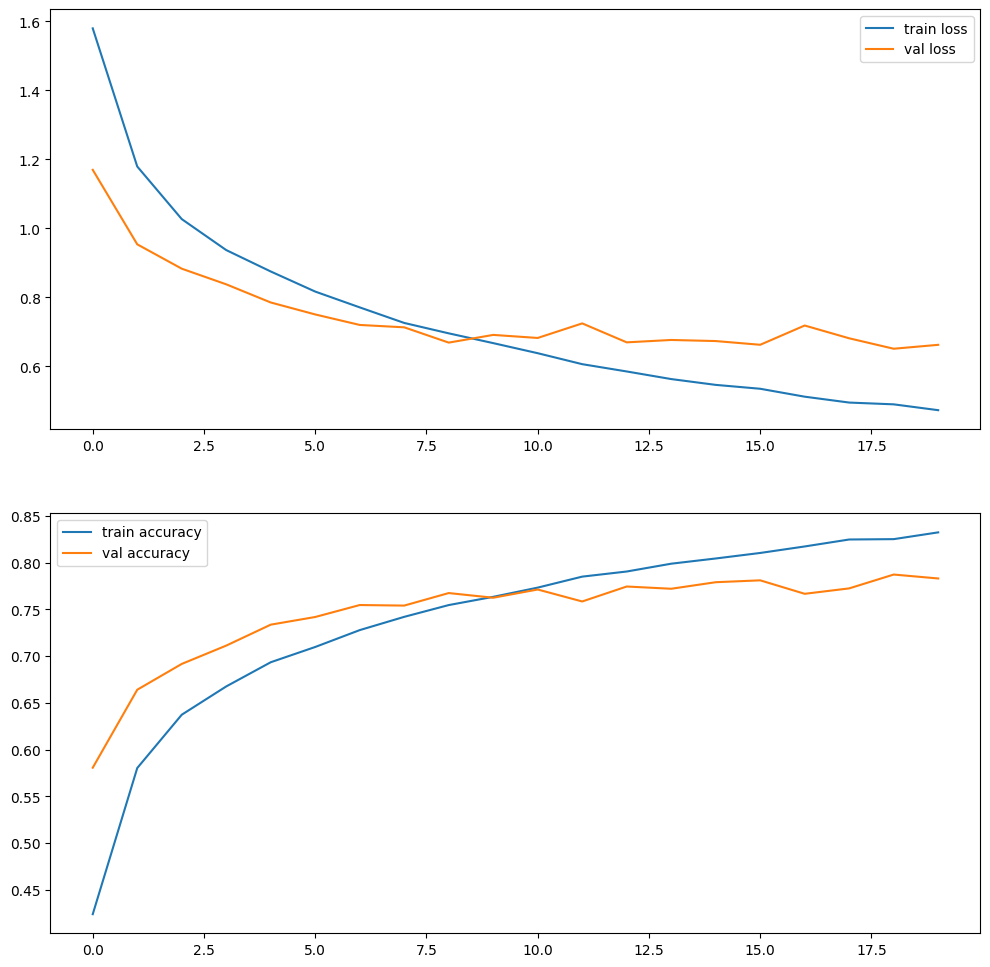

In [56]:
print('val_loss: ', val_loss3, 'val_acc: ', val_acc3)

plot.figure(figsize=(12, 6))

figure, plot_arr = plot.subplots(2)

plot_arr[0].plot(history3.epoch, history3.history['loss'], label='train loss')
plot_arr[0].plot(history3.epoch, history3.history['val_loss'], label='val loss')
plot_arr[0].legend()

plot_arr[1].plot(history3.epoch, history3.history['accuracy'], label='train accuracy')
plot_arr[1].plot(history3.epoch, history3.history['val_accuracy'], label='val accuracy')
plot_arr[1].legend()

plot.show()

Можно заметить, что данная модель показывает намного худшие результаты, точность при валидации оказалась меньше 50%, что делает модель нежизнеспособной.

Модель 4:

Возьмём исходную модель, но изменим количество ядер на всех сверточных слоях с 3 на 6:

In [54]:
kernel_size = 6

model4 = Sequential(
    [
        Conv2D(conv_depth_1, (kernel_size, kernel_size), padding="same", activation='relu', input_shape=(depth, height, width)),
        Conv2D(conv_depth_1, (kernel_size, kernel_size), padding="same", activation='relu'),
        MaxPooling2D(pool_size=(pool_size, pool_size)),
        Dropout(drop_prob_1),
        Conv2D(conv_depth_2, (kernel_size, kernel_size), padding="same", activation='relu'),
        Conv2D(conv_depth_2, (kernel_size, kernel_size), padding="same", activation='relu'),
        MaxPooling2D(pool_size=(pool_size, pool_size)),
        Dropout(drop_prob_1),
        Flatten(),
        Dense(hidden_size, activation='relu'),
        Dropout(drop_prob_2),
        Dense(num_classes, activation='softmax')
    ]
)
with tf.device("/GPU:0"):
    model4.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(jit_compile=True), metrics=['accuracy'])
    history4 = model4.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, validation_split=0.1)
val_loss4, val_acc4 = model4.evaluate(X_test, Y_test, verbose=1)

Epoch 1/20
1407/1407 [==============================] - 150s 106ms/step - loss: 1.7148 - accuracy: 0.3702 - val_loss: 1.3989 - val_accuracy: 0.4780
Epoch 2/20
1407/1407 [==============================] - 148s 105ms/step - loss: 1.3983 - accuracy: 0.4960 - val_loss: 1.2301 - val_accuracy: 0.5444
Epoch 3/20
1407/1407 [==============================] - 148s 105ms/step - loss: 1.2677 - accuracy: 0.5453 - val_loss: 1.1305 - val_accuracy: 0.5972
Epoch 4/20
1407/1407 [==============================] - 148s 105ms/step - loss: 1.1795 - accuracy: 0.5778 - val_loss: 1.0573 - val_accuracy: 0.6232
Epoch 5/20
1407/1407 [==============================] - 148s 105ms/step - loss: 1.1076 - accuracy: 0.6069 - val_loss: 1.0066 - val_accuracy: 0.6522
Epoch 6/20
1407/1407 [==============================] - 148s 105ms/step - loss: 1.0539 - accuracy: 0.6285 - val_loss: 0.9762 - val_accuracy: 0.6618
Epoch 7/20
1407/1407 [==============================] - 148s 105ms/step - loss: 1.0071 - accuracy: 0.6442 - val_

1. Выведем результаты прогона тестовых данных через модель
2. Отобразим на графиках попарно изменения loss и val_loss, accuracy и val_accuracy от номера эпохи:

val_loss:  224.80914306640625 val_acc:  0.45719999074935913


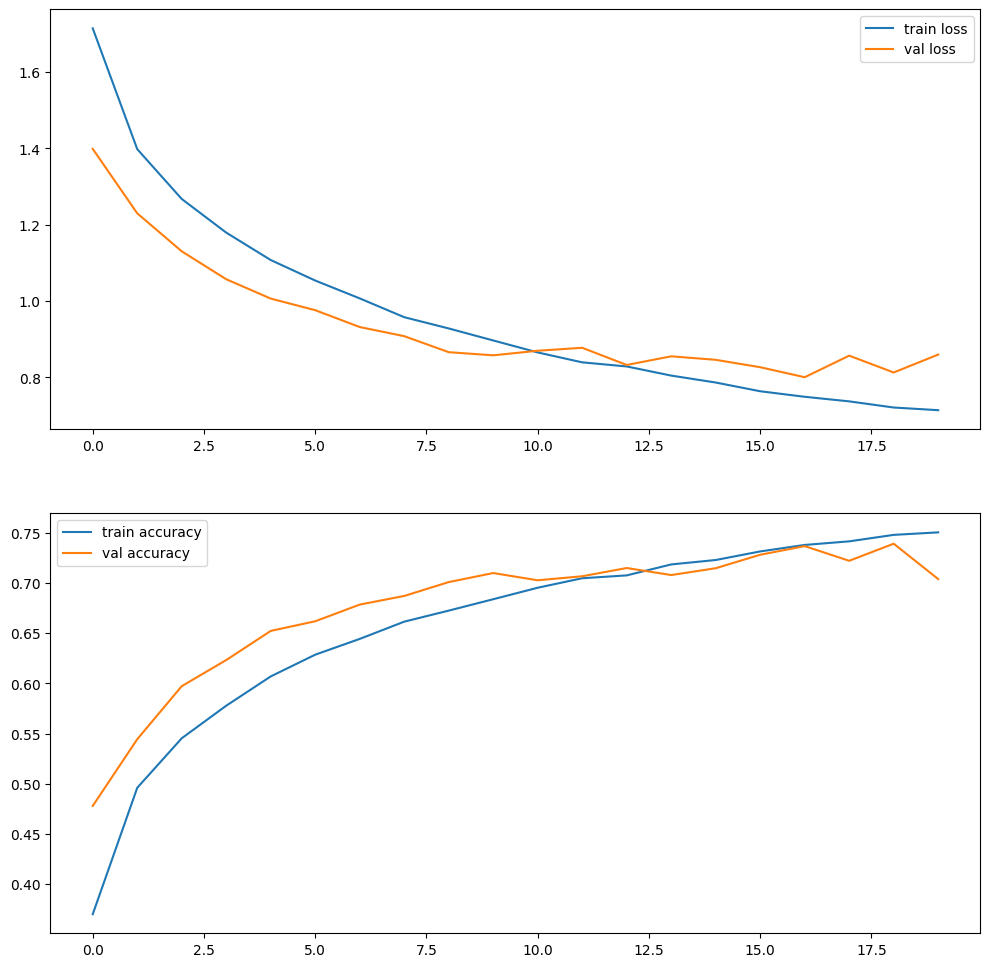

In [57]:
print('val_loss: ', val_loss4, 'val_acc: ', val_acc4)

plot.rcParams["figure.figsize"] = (12, 12)

figure, plot_arr = plot.subplots(2)

plot_arr[0].plot(history4.epoch, history4.history['loss'], label='train loss')
plot_arr[0].plot(history4.epoch, history4.history['val_loss'], label='val loss')
plot_arr[0].legend()

plot_arr[1].plot(history4.epoch, history4.history['accuracy'], label='train accuracy')
plot_arr[1].plot(history4.epoch, history4.history['val_accuracy'], label='val accuracy')
plot_arr[1].legend()

plot.show()

Можно заметить, что данная модель показала себя лучше чем модель 3, однако всё ещё точность оказалась ниже 50%

Результаты:

Объеденим графики тренировочных и тестовых значений потерь и точности для всех моделей: 

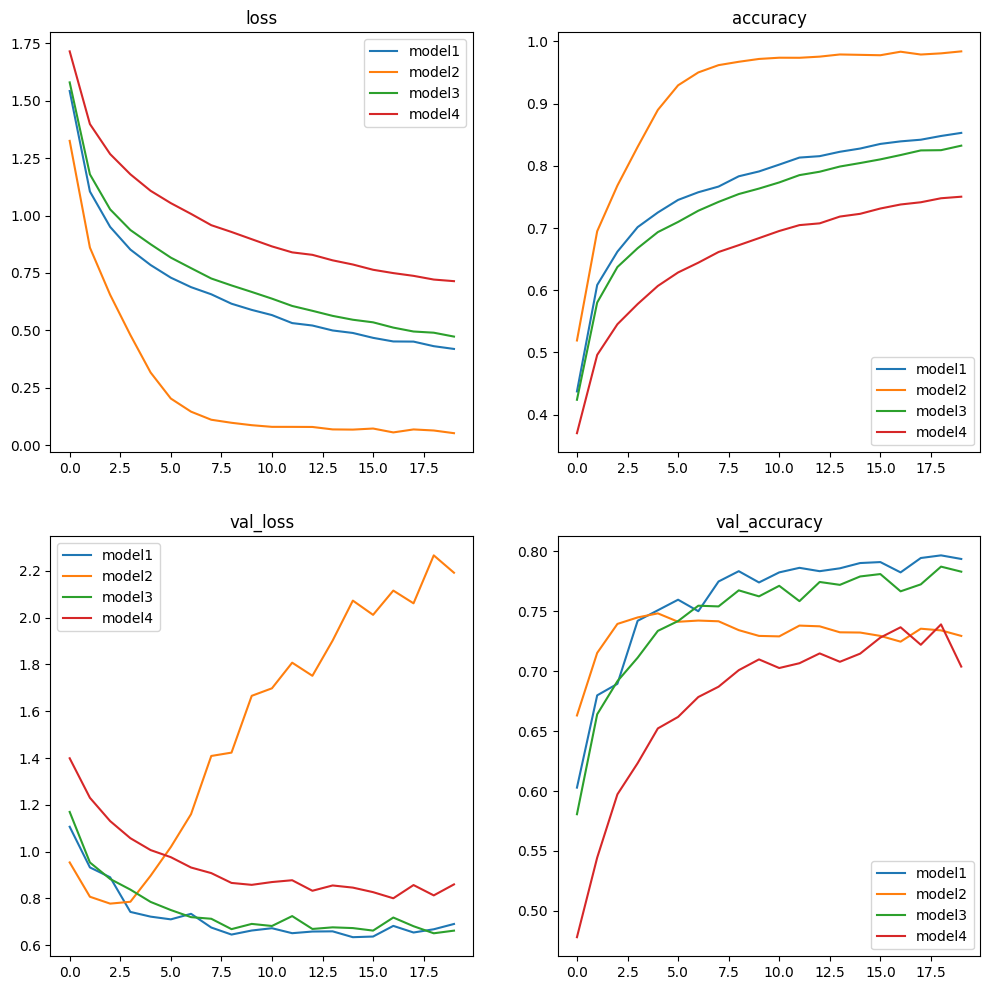

In [58]:
plot.rcParams["figure.figsize"] = (12, 12)

figure, plot_arr = plot.subplots(2, 2)

plot_arr[0, 0].set_title('loss')
plot_arr[0, 0].plot(history1.epoch, history1.history['loss'], label='model1')
plot_arr[0, 0].plot(history2.epoch, history2.history['loss'], label='model2')
plot_arr[0, 0].plot(history3.epoch, history3.history['loss'], label='model3')
plot_arr[0, 0].plot(history4.epoch, history4.history['loss'], label='model4')
plot_arr[0, 0].legend()

plot_arr[0, 1].set_title('accuracy')
plot_arr[0, 1].plot(history1.epoch, history1.history['accuracy'], label='model1')
plot_arr[0, 1].plot(history2.epoch, history2.history['accuracy'], label='model2')
plot_arr[0, 1].plot(history3.epoch, history3.history['accuracy'], label='model3')
plot_arr[0, 1].plot(history4.epoch, history4.history['accuracy'], label='model4')
plot_arr[0, 1].legend()

plot_arr[1, 0].set_title('val_loss')
plot_arr[1, 0].plot(history1.epoch, history1.history['val_loss'], label='model1')
plot_arr[1, 0].plot(history2.epoch, history2.history['val_loss'], label='model2')
plot_arr[1, 0].plot(history3.epoch, history3.history['val_loss'], label='model3')
plot_arr[1, 0].plot(history4.epoch, history4.history['val_loss'], label='model4')
plot_arr[1, 0].legend()

plot_arr[1, 1].set_title('val_accuracy')
plot_arr[1, 1].plot(history1.epoch, history1.history['val_accuracy'], label='model1')
plot_arr[1, 1].plot(history2.epoch, history2.history['val_accuracy'], label='model2')
plot_arr[1, 1].plot(history3.epoch, history3.history['val_accuracy'], label='model3')
plot_arr[1, 1].plot(history4.epoch, history4.history['val_accuracy'], label='model4')
plot_arr[1, 1].legend()

plot.show()

Тестовые точность и потери:

In [59]:
print('[model1] val_loss: ', val_loss1, 'val_acc', val_acc1)
print('[model2] val_loss: ', val_loss2, 'val_acc', val_acc2)
print('[model3] val_loss: ', val_loss3, 'val_acc', val_acc3)
print('[model4] val_loss: ', val_loss4, 'val_acc', val_acc4)


[model1] val_loss:  145.76361083984375 val_acc 0.6255000233650208
[model2] val_loss:  862.0443725585938 val_acc 0.5375999808311462
[model3] val_loss:  373.459228515625 val_acc 0.4092000126838684
[model4] val_loss:  224.80914306640625 val_acc 0.45719999074935913


Можно сделать вывод, что первая модель показала себя лучше всех. Вторая модель, в которой отсутствуют слои исключений, показала себя немного хуже, сказывается переобучение. 3 и 4 дают примерно одинаковые результаты.

Есть ещё одна общая для всех моделей тенденция - результаты на тренировочных данных куда лучше чем результаты на тестовых данных, то есть во всех моделях сильно сказывается фактор переобучения